<a href="https://colab.research.google.com/github/lucasestrela/Dissertacao/blob/main/Calculando_Custo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Importanto Pacotes

In [ ]:
#!pip install statsmodels --upgrade

In [2]:
import numpy as np
import pandas as pd # Para manipular os dados
import warnings
from statsmodels.tsa.arima_model import ARMA # Versao antiga da fç
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.stattools import arma_order_select_ic
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

warnings.filterwarnings('ignore')

# 2) Definindo Funções

As funções abaixo se referem:

a) *calculate_best_arima()* : Calcula o melhor ARMA(p,q) para um dado *dataframe* e retorna a 1) tabela de regressão; 2) (p,q); 3) Os valores dos coeficientes AR e MA; 3) Variância do erro desta regressão;

b) *ma_infinite_representation2()* : Para um dado ARMA(p,q) faz a inversão para um MA($\infty$) truncado em T (grande);

c) *matriz_custo()* : Para um dado MA($\infty$), variância do erro, e grids do desconto intertemporal $\rho$ e aversão relativa ao risco $\gamma$, calcula o custo de bem estar

In [3]:
###################################################
############## --- Funcoes uteis --- ##############
###################################################


def calculate_best_arima(data_frame):
    # Seleciono o melhor (p,q) usando criterio de selecao Bayesiano
    # max (5, 5) provisoriamente
    res1 = arma_order_select_ic(data_frame,
                                max_ar = 3, max_ma = 4, 
                                ic = ['bic'],
                                fit_kw={'method':'css-mle'},
                                trend = 'c'
                                )
    

    model = ARMA(data_frame, 
                 order = (res1.bic_min_order[0], res1.bic_min_order[1])
                 )
    
    res = model.fit(transparams = False, 
                    disp=0
                    ) 

    
    AR, MA = res.arparams, res.maparams
    
    
    var = sum( (data_frame - res.predict())**2 )/(len(data_frame) - (len(AR) + len(MA) + 1) )
    
    return res, res1.bic_min_order, AR, MA, var
    

def ma_infinite_representation2(AR, MA, T = 10000):

    Pol = np.zeros(T)
    
    if len(MA) == 0:
        MA = [0]
        
    if len(AR) == 0:
        AR = [0]
    
    
    
    # O que quero construir:
    Pol[0] = 1
    Pol[1] = MA[0] + AR[0]
    # Pol[2] = MA[1] + AR[1]*Pol[0] + AR[0]*Pol[1]
    # Pol[3] = MA[2] + AR[2]*Pol[0] + AR[1]*Pol[1] + AR[0]*Pol[2]
    # Pol[4] = MA[3] + AR[3]*Pol[0] + AR[2]*Pol[1] + AR[1]*Pol[2] + AR[0]*Pol[3]
    # Pol[5] = MA[4] + AR[4]*Pol[0] + AR[3]*Pol[1] + AR[2]*Pol[2] + AR[1]*Pol[3] + AR[0]*Pol[4]
        

    # Podem, pode surgir problema de dimensionalidade dos coeficientes
    # ex. ARMA(0,0) ou MA(1).. Entao completo as dimensões restantes
    # do ARMA como 0, ja que os coef são, de fato, zero.
    
    AR_teste = np.append(AR, np.zeros(T-len(AR)
                                      )
                         )
       
    MA_teste = np.append(MA, np.zeros(T-len(MA)
                                      )
                         )


    for i in range(2, T):
                  
        # Virando de tras pra frente
        AR_m = np.flip(AR_teste[0:i])
        
        # Calculando o iesimo termo
        Pol[i] = MA_teste[i - 1] + np.dot(Pol[0:i], AR_m)

    return Pol


def matriz_custo( MA_inf, var_u, Rho = np.array([0.03, 0.02, 0.01]), Gamma = np.array([1, 3, 5]), T = 10000):
    
    lambda_ARMA = np.zeros(
                          ( len(Rho),len(Gamma) )
                          )
    
    Exp = np.zeros(T)

    Acumulado = np.cumsum(MA_inf**2)
    Acumulado = np.cumsum(Acumulado)
    
    
    for i in range(0, len(Rho)):   
        for j in range(0, len(Gamma)):   
            for t in range(0, T):
                
                Exp[t] = np.exp(-Rho[i]*t)
                
        
            if Gamma[j] < 1.1:
                    
                Soma = np.dot(Exp, Acumulado)
                
                # Exp(1) no matlab retorna 2.7183. No numpy 2.718281828459045
                lambda_ARMA[i, j] = np.exp(0.5 * (var_u) * (1 - np.exp(-Rho[i]) ) * Soma) - 1
                 
                
            else:
                    
                Soma = np.exp(0.5 * (var_u) * Gamma[j] * (Gamma[j]-1) * Acumulado)
                parte = 1 + np.dot(Exp, Soma)
                lambda_ARMA[i, j] = np.exp( (np.log( (1-np.exp(-Rho[i])) * parte) ) / ( Gamma[j]-1 ) )  - 1
                                               

    return lambda_ARMA


Na última função, em particular, calculamos a seguinte somatória:


\begin{align*}
    \ln(1+\lambda) = 
        \begin{cases}
           \frac{1}{2} \sigma^2_u (1-e^\rho ) \Big(\sum^{\infty}_{t=1} e^{\rho t} \sum_{t-1}^{j=0} \alpha_i^2 \Big), \quad se \quad \gamma = 1 \\
           (\gamma - 1)^{-1} \ln \Big [ (1- e^{\rho}) (1+ \sum_{\infty}^{t=1} e^{\rho t} e^{0,5 \sigma^2_u \gamma (\gamma-1) \sum^{t-1}_{j=0} \sum^{j}_{i=0} \alpha_i^2}) \Big], \quad se \quad \gamma \neq 1
        \end{cases}
\end{align*}

# 3) Importando Dados

Nesta seção utilizo dados da PWT 10.0

In [4]:
###################################################################
############## --- Abrindo Bases e Transformando --- ##############
###################################################################

# Abrindo a base
url = 'https://www.rug.nl/ggdc/docs/pwt100.xlsx'
pwt = pd.read_excel(url,
                    sheet_name = 'Data'
                    )


#Selecionando apenas as variaveis que vou utilizar
pwt = pwt[['country', 'countrycode', 'year', 'cgdpo','csh_c', 'pop']]

# Filtro os anos
pwt = pwt[pwt['year'] <= 2011]
pwt = pwt[pwt['year'] >= 1951]

# Crio variavel log do cons. percapita
pwt['cons_pcapta'] = np.log(pwt['cgdpo']*pwt['csh_c']/pwt['pop'])

countries = pwt['country'].unique()
country_codes = pwt['countrycode'].unique()

# 4) Calculando o custo

In [5]:
# Criando listas que armazenarão o output do modelo
models      = [None] * len(countries)
best_ARMA   = [None] * len(countries) 
results     = [None] * len(countries)
lambda_ARMA = [None] * len(countries)

In [6]:
for idx, country in enumerate(countries):
        
    try:
        #Eliminando NA e diferenciando
        newdf = pwt[(pwt['country'] == country) ].dropna()
        newdf = newdf['cons_pcapta'].diff().dropna()
    
        data_frame = newdf
    
        # Calculando o melhor ARMA
        models[idx], best_ARMA[idx], MA_coef, AR_coef, variance = calculate_best_arima(newdf)
    
    
        #Transformando MA(inf)
        Pol = ma_infinite_representation2(AR = AR_coef, 
                                          MA = MA_coef)
    
    
        #Calculando custo do ciclo
        lambda_ARMA[idx] = matriz_custo(MA_inf = Pol, 
                                        var_u = variance,
                                        # Rho = np.array([0.001]),
                                        # Gamma = np.array([3])
                                        Rho = np.arange(0.03, 0.001, -0.01),
                                        Gamma = np.arange(1, 6, 2)
                                        )
        print(f'[Num, País, Variance] = {idx:3} | {country:20} | {np.round(variance,4):6} | best_ARMA')
        
    except:
        print(f'[Num, País, Variance] = {idx:3} | {country:20} | País Não Inversível')

[Num, País, Variance] =   0 | Aruba                | 0.0014 | best_ARMA
[Num, País, Variance] =   1 | Angola               | 0.0313 | best_ARMA
[Num, País, Variance] =   2 | Anguilla             | 0.0235 | best_ARMA
[Num, País, Variance] =   3 | Albania              | 0.0032 | best_ARMA
[Num, País, Variance] =   4 | United Arab Emirates | 0.0337 | best_ARMA
[Num, País, Variance] =   5 | Argentina            | 0.0057 | best_ARMA
[Num, País, Variance] =   6 | Armenia              | 0.0036 | best_ARMA
[Num, País, Variance] =   7 | Antigua and Barbuda  | 0.0276 | best_ARMA
[Num, País, Variance] =   8 | Australia            | 0.0006 | best_ARMA
[Num, País, Variance] =   9 | Austria              | 0.0006 | best_ARMA
[Num, País, Variance] =  10 | Azerbaijan           | 0.0074 | best_ARMA
[Num, País, Variance] =  11 | Burundi              | 0.0054 | best_ARMA
[Num, País, Variance] =  12 | Belgium              | 0.0006 | best_ARMA
[Num, País, Variance] =  13 | Benin                | 0.0024 | be

In [7]:
del idx, country, MA_coef, AR_coef, variance, Pol

# 5) Exportando os dados

In [8]:
custo = [None] * len(countries)

for idx in range(0, len(countries)):
    
    try:
        custo[idx] = lambda_ARMA[idx][0,0]*100
        
    except:
        custo[idx] = None


custo = {'custo' : custo, 'countrycode' : country_codes}
custo = pd.DataFrame(custo, columns=['custo', 'countrycode'])

In [9]:
# Exportanto dados

custo.to_csv('custos_data.csv')
files.download('custos_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 6) Graficos



### 6.1) Verificando sensibilidade do custo em $\gamma$ e $\rho$


In [16]:
np.set_printoptions(suppress=True)

country = 'Brazil'

#Eliminando NA e diferenciando
newdf = pwt[(pwt['country'] == country) ].dropna()
newdf = newdf['cons_pcapta'].diff().dropna()

# Calculando o melhor ARMA
models2, best_ARMA2, MA_coef, AR_coef, variance = calculate_best_arima(newdf)

#Transformando MA(inf)
Pol = ma_infinite_representation2(AR = AR_coef, 
                                  MA = MA_coef)

lambda_ARMA2 = matriz_custo(MA_inf = Pol, 
                            var_u = variance,
                            Rho = np.arange(0.03, 0.01, -0.001),
                            Gamma = np.arange(0, 4, 0.2)
                            )


Note que o custo cresce exponencialmente em $\gamma$ e decresce em $\rho$

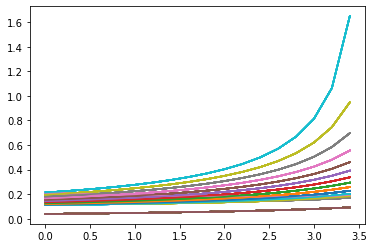

In [17]:

for i in range(0, lambda_ARMA2.shape[0] ) :
    plt.plot(np.arange(0, 4, 0.2)[:-2], lambda_ARMA2[:-2,:])
     
plt.show()


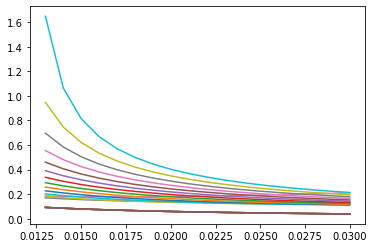

In [18]:
for i in range(0, lambda_ARMA2.shape[1] ) :
    plt.plot(np.arange(0.03, 0.01, -0.001)[:-2], lambda_ARMA2[:-2,i])
    
plt.show()

### 6.2) Plotando os melhores ARMAS

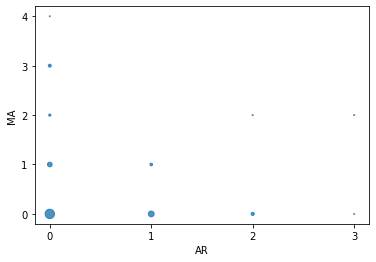

In [19]:
# Selecionando os melhores ARMA mas excluindo os paises que nao sao inversiveis
best_ARMA2 = [x for x in best_ARMA if x is not None]

# Total de modelos na respectiva especificação
Vetor = pd.DataFrame({'a':best_ARMA2})
Vetor = pd.DataFrame(Vetor['a'].value_counts())

# Transformando o DF para obter uma coluna da ordem do MA e outra do AR
Vetor['AR'] = pd.DataFrame([AR[0] for AR in Vetor.index], index = Vetor.index)
Vetor['MA'] = pd.DataFrame([MA[1] for MA in Vetor.index], index = Vetor.index)


# Plotando o grafico
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x = Vetor['AR'], y = Vetor['MA'], s = Vetor['a'], alpha=0.8)
ax.set(
    xlabel='AR',
    ylabel='MA'
)
plt.xticks([0, 1, 2, 3])
plt.yticks([0, 1, 2, 3, 4])


del fig, ax

### 6.3) Plotando o histograma dos custos

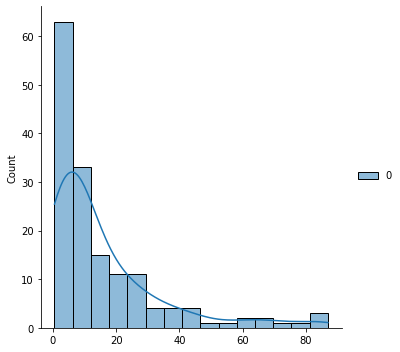

Existem 156 países com custo < 100%
Parametros: Rho = 0.03 ; e Gamma =  1



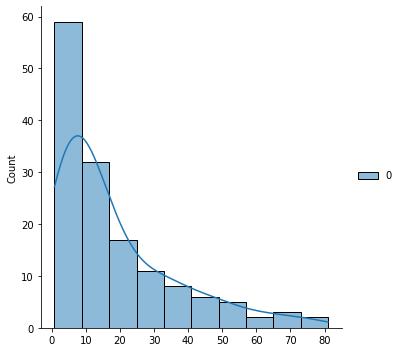

Existem 145 países com custo < 100%
Parametros: Rho = 0.03 ; e Gamma =  3



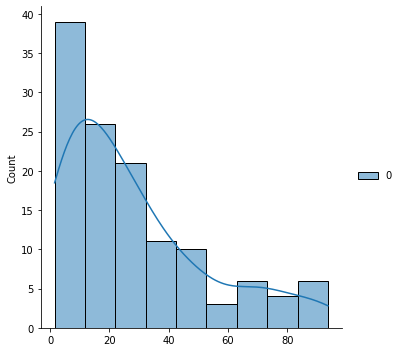

Existem 126 países com custo < 100%
Parametros: Rho = 0.03 ; e Gamma =  5



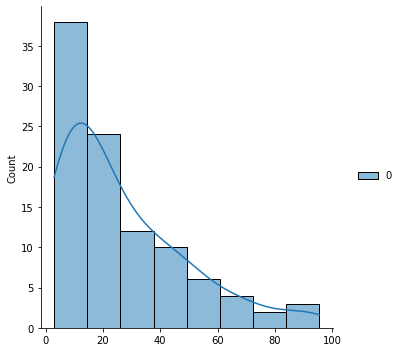

Existem 99 países com custo < 100%
Parametros: Rho = 0.02 ; e Gamma =  1



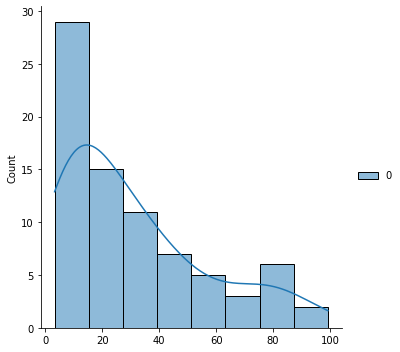

Existem 78 países com custo < 100%
Parametros: Rho = 0.02 ; e Gamma =  3



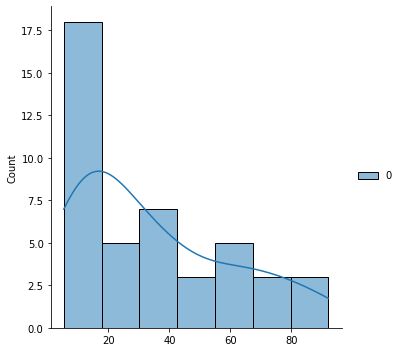

Existem 44 países com custo < 100%
Parametros: Rho = 0.02 ; e Gamma =  5



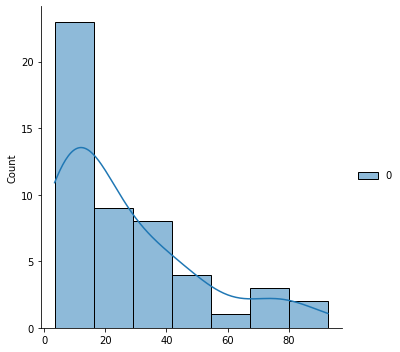

Existem 50 países com custo < 100%
Parametros: Rho = 0.01 ; e Gamma =  1



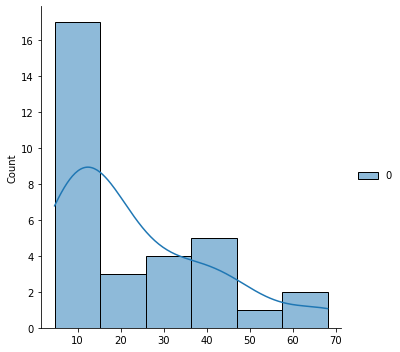

Existem 32 países com custo < 100%
Parametros: Rho = 0.01 ; e Gamma =  3



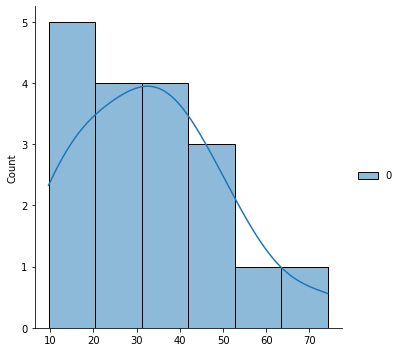

Existem 18 países com custo < 100%
Parametros: Rho = 0.01 ; e Gamma =  5



In [20]:
Rho = np.arange(0.03, 0.001, -0.01)
Gamma = np.arange(1, 6, 2)


custo = [None] * len(countries)
    
for j, rhho in enumerate(Rho):
    for i, gama in enumerate(Gamma):
        
        custo = [None] * len(countries)
        
        for idx in range(0, len(countries)):
            
            try:
                custo[idx] = lambda_ARMA[idx][i,j]*100
                
            except:
                custo[idx] = None
        
        custo = pd.DataFrame(custo)
        
        # Existem custos muito altos
        custo.describe()
        
        #Removo os custos acima de 100%
        custo = custo[custo < 100]  
        
        # Histograma 
        # plt.hist(custo, bins = 80)
        # plt.show()
        
        # Densidade 1
        # sns.displot(custo, kind="kde", bw_adjust=.5, 
        #              cut=0)
        # plt.show()
    
        # Densidade 2
        sns.displot(custo, kde=True)
        plt.show()
        
        print('Existem', custo[0].notnull().sum(), 'países com custo < 100%')
        print('Parametros: Rho =', np.round(rhho, 3), '; e Gamma = ', np.round(gama, 3))
        print()

del j, i, idx